<a href="https://colab.research.google.com/github/pieva/SimPy/blob/main/SimPy_Queuing_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### https://github.com/jdbrawn/SimPy-Queuing-Simulation/blob/master/A4.py

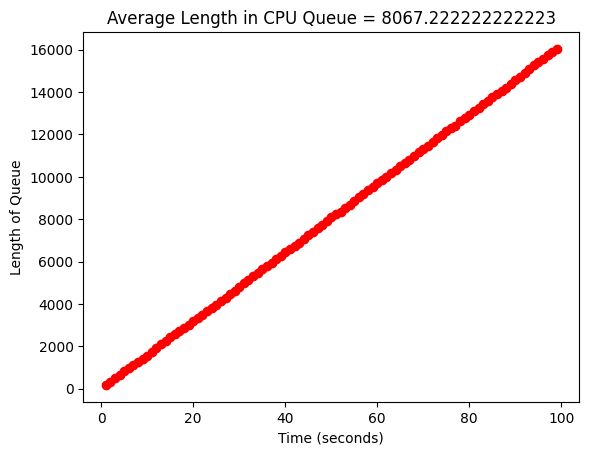

TRACKING EACH PACKET:
Standard Deviation: 0.0
CPU Queue Mean: 0.0
Number of Samples: 2
CPU Queue 95% Confidence interval = +- 0.0
CPU Queue 98% Confidence interval = +- 0.0

Response Time Mean: 0.016028673636293747
Response Time 95% Confidence interval = +- 0.0
Response Time 98% Confidence interval = +- 0.0

Lambda CPU = 161.71
Lambda Network = 0.01
Lambda Disk = 0.0

TAKING SIZE AT EACH SECOND:
Standard Deviation: 4638.658268990708
CPU Queue Mean: 8067.222222222223
Number of Samples: 99
CPU Queue 95% Confidence interval = +- 913.757286590498
CPU Queue 98% Confidence interval = +- 1086.2522845693165


In [38]:
!pip install simpy

from __future__ import division
import random
import simpy
import numpy as np
import matplotlib.pyplot as plt

# First Name: John
# Last Name: Brawn
# BU ID: U32447749

class Parameters:
    '''In this class, you must just define the following variables of your distribution:
    These variables will be hardcoded with values. Please refer to the assignment handout what
    these values must be. You can use the values appropriately in your code by calling Parameters.NAME_OF_VARIABLE
    --For Poisson Arrivals and Exponential Service Time
      1) lambda for poisson arrivals
      2) Ts for service time

    --For Uniform Arrivals and Uniform Service Time
       3) interarrivalTimeMin and interarrivalTimeMax for Uniform distribution.
       4) serviceTimeMin and serviceTimeMax for Uniform distribution.
    5. numberOfServers in your computing system
    6. simulationTime in hrs. '''

    MAX_TIME = 100

    LAMBDA = 0.025
    TScpu = 0.02
    TSdisk = 0.1
    TSnet = 0.025

    xVal = 1
    xPasta = []
    yPasta = []
    #y = [0 for x in range(100)]
    x = []
    y = []
    total = 0

    packetTimes = []

    Lcpu = 0
    Lnet = 0
    Ldisk = 0

    Prob3 = False
    MIN_SERVICE = 0.001
    MAX_SERVICE = 0.039


##### Processes #####
# Customer
class Packet(simpy.Process):
    def __init__(self, env, cs, disk, net):
        super().__init__(env, self.behavior_of_single_packet(cs, disk, net))

    def behavior_of_single_packet(self, cs, disk, net):
        '''You must implement this method. This method is the behavior of a single packet
        when it interacts with the queue of your computing system. These are some questions you will want to think about
        1. What happens when the packet arrives? Does it get serviced immediately or gets put in the queue?
        2. If it does get serviced, how long will it be serviced for? Or does it get put in the queue?
        3. When does it depart?

        The cs in the method is an instance of the Computing System class'''

        currentProc = "CPU"
        inSystem = True
        tCreate = env.now

        while inSystem:


            if env.now >= Parameters.xVal:
                Parameters.xPasta.append(env.now)
                Parameters.yPasta.append(len(cs.queue))
                Parameters.xVal += 1


            if currentProc == "CPU":

                Parameters.Lcpu += 1
                # Customer arrives, joins queue
                #arrive = env.now
                #print ('Time {}: {} arrived and about to join the CPU queue'.format(env.now, self.name))
                req = yield cs.request()
                #wait = env.now - arrive
                #c.observe(wait)

                if env.now > 00:
                    Parameters.x.append(env.now)
                    Parameters.y.append(len(cs.queue))
                    Parameters.total += len(cs.queue)


                #print ('Time {}: {} is about to get its CPU service initiated'.format(env.now, self.name))
                if Parameters.Prob3:
                    t = uniform(Parameters.MIN_SERVICE, Parameters.MAX_SERVICE)
                else:
                    t = np.random.exponential(Parameters.TScpu)
                yield env.timeout(t)
                yield cs.release(req)
                #print ('Time {}: {} CPU service terminated and exits'.format(env.now, self.name))

                prob = np.random.uniform()
                if prob < 0.1:
                    currentProc = "Disk"
                elif prob < 0.5:
                    currentProc = "Net"
                else:
                    inSystem = False
                    Parameters.packetTimes.append(env.now-tCreate)

            elif currentProc == "Disk":

                Parameters.Ldisk += 1
                # Customer arrives, joins queue
                # print ('Time {}: {} arrived and about to join the DISK queue'.format(env.now, self.name))
                req = yield disk.request()

                # print ('Time {}: {} is about to get its service initiated'.format(env.now, self.name))
                if Parameters.Prob3:
                    t = np.random.normal(0.1, 0.03)
                    while t <= 0:
                        t = np.random.normal(0.1, 0.03)
                else:
                    t = np.random.exponential(Parameters.TSdisk)
                yield env.timeout(t)
                yield disl.release(req)
                # print ('Time {}: {} service terminated and exits'.format(env.now, self.name))

                prob = np.random.uniform()
                if prob < 0.5:
                    currentProc = "CPU"
                else:
                    currentProc = "Net"

            elif currentProc == "Net":

                Parameters.Lnet += 1
                # Customer arrives, joins queue
                # print ('Time {}: {} arrived and about to join the NET queue'.format(env.now, self.name))
                req = yield net.request()

                # print ('Time {}: {} is about to get its service initiated'.format(env.now, self.name))
                if Parameters.Prob3:
                    t = 0.025
                else:
                    t = np.random.exponential(Parameters.TSnet)

                arriveS = env.now
                yield env.timeout(t)
                yield net.release(req)
                # print ('Time {}: {} service terminated and exits'.format(env.now, self.name))

                currentProc = "CPU"

class PacketGenerator(simpy.Process):
    def __init__(self, env, cs, disk, net):
        super().__init__(env, self.createPackets(cs, disk, net))
        self.cs = cs
        self.disk = disk
        self.net = net

    def createPackets(self, cs, disk, net):
        i = 0

        while True:
            t = np.random.exponential(Parameters.LAMBDA)

            yield env.timeout(t)  # Change from 'hold' to 'timeout'
            c = Packet(env, cs, disk, net)
            env.process(c.behavior_of_single_packet(cs, disk, net))  # Change from 'activate' to 'env.process'
            i += 1


#You do not need to modify this class.
class ComputingSystem(simpy.Resource):
    pass


#You can modify this model method#.
def model(env):
    # Seed the generator using seed value of 123.
    np.random.seed(123)
    cpu = ComputingSystem(env, capacity=2)
    disk = ComputingSystem(env, capacity=1)
    net = ComputingSystem(env, capacity=1)

    generator = PacketGenerator(env, cs=cpu, disk=disk, net=net)
    env.process(generator.createPackets(cpu, disk, net))

    env.run(until=Parameters.MAX_TIME)  # Use env.run(until=...) to start the simulation


# TOGGLE ON/OFF FOR PROBLEM 3
Parameters.Prob3 = False

env = simpy.Environment()
model(env)


# TOGGLE ON/OFF FOR PLOTTING TRACKING AT EVERY SECOND
plt.plot(Parameters.xPasta, Parameters.yPasta, 'ro')
plt.title("Average Length in CPU Queue = " + str(np.mean(Parameters.yPasta)))
plt.ylabel("Length of Queue")
plt.xlabel("Time (seconds)")
plt.show()

print("TRACKING EACH PACKET:")
print("Standard Deviation: " + str(np.std(Parameters.y)))
print("CPU Queue Mean: " + str(np.mean(Parameters.y)))
print("Number of Samples: " + str(len(Parameters.y)))
print("CPU Queue 95% Confidence interval = +- " + str(1.96 * (np.std(Parameters.y)/np.sqrt(len(Parameters.y)))))
print("CPU Queue 98% Confidence interval = +- " + str(2.33 * (np.std(Parameters.y)/np.sqrt(len(Parameters.y)))))
print()
print("Response Time Mean: " + str(np.mean(Parameters.packetTimes)))
print("Response Time 95% Confidence interval = +- " + str(1.96 * (np.std(Parameters.packetTimes)/np.sqrt(len(Parameters.packetTimes)))))
print("Response Time 98% Confidence interval = +- " + str(2.33 * (np.std(Parameters.packetTimes)/np.sqrt(len(Parameters.packetTimes)))))
print()
print("Lambda CPU = " + str(Parameters.Lcpu / Parameters.MAX_TIME))
print("Lambda Network = " + str(Parameters.Lnet / Parameters.MAX_TIME))
print("Lambda Disk = " + str(Parameters.Ldisk / Parameters.MAX_TIME))
print()
print("TAKING SIZE AT EACH SECOND:")
print("Standard Deviation: " + str(np.std(Parameters.yPasta)))
print("CPU Queue Mean: " + str(np.mean(Parameters.yPasta)))
print("Number of Samples: " + str(len(Parameters.yPasta)))
print("CPU Queue 95% Confidence interval = +- " + str(1.96 * (np.std(Parameters.yPasta)/np.sqrt(len(Parameters.yPasta)))))
print("CPU Queue 98% Confidence interval = +- " + str(2.33 * (np.std(Parameters.yPasta)/np.sqrt(len(Parameters.yPasta)))))
